In [2]:
# exercise 13.9
#下载 Large Movie Review Dataset，它包含 50000 条 IMDB 的影评。数据分为两个目录，train和test，
#每个包含 12500 条正面评价和 12500 条负面评价。每条评价都存在独立的文本文件中。

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses

# IMDB review

In [25]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

#获取目录结构
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

In [26]:
#train目录结构
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'unsup']

In [19]:
#随机读取一条评论
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [27]:

# 正面负面评论分别位于  aclImdb/train/pos 和 aclImdb/train/neg
# 删除unsup 
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [28]:
#没有unsup文件夹了
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [29]:
#文件夹有train test数据集，缺少valid数据集
#通过validation_split 参数，使用 80:20 拆分训练数据来创建验证集。
#使用 text_dataset_from_directory 工具进行二元分类，不同文件夹的文本即对应不同标签
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [30]:
#取一批raw_train 数据（32个），打印三个
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"Mild Spoilers<br /><br />In the near future, Arnold stars as Ben Richards, a wrongly convicted man coerced into playing 'The Running Man', a deadly TV game show where people have to keep moving to try and escape brutal deaths at the hands of the 'Stalkers'. Of course, people are expected to die eventually and its up to Arnold to prove the system wrong.<br /><br />I haven't read the Stephen King book, but this is a great film regardless, one of Arnold's best. He does what he does best in the action man role, delivering death with unforgettable one-liners. Classics are probably the 'He was a real pain in the neck' after strangling a guy with barb wire, and 'He had to split!', referring to whereabouts he just chain sawed someone vertically. Dawson is perfectly irritating as the TV presenter, and all the 'Stalkers' are suitably camp. The action is violent, but its an action film. That's the point. The film is fast paced, and at 90 minutes it doesn't overstay its welcome. <br /><br

In [31]:
#通过文件名和label名，确定label 0 表示 neg，label 1 表示 pos
raw_train_ds.class_names

['neg', 'pos']

In [32]:
#取验证集,确保和之前获取训练集函数使用一样的seed
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [33]:
#测试集 25000个
test_dir=os.path.join(dataset_dir,"test")
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [34]:
# 使用tf.keras.layers.TextVectorization 层对数据进行标准化、词例化和向量化
# 为在训练和测试时间对数据进行相同的预处理，将 TextVectorization 层直接包含在模型中
# 定义标准输入函数，处理大小写和换行符

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) #小写处理
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #把<br /> 替换为空格
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),'')

#最后一行表示将所有标点符号正则转译为空符号

In [35]:
#创建一个 TextVectorization 层，该层对我们的数据进行标准化、词例化和向量化。
#调用了之前定义的标准化函数
#将 output_mode 设置为 int 以便为每个词例创建唯一的整数索引。

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [36]:
#调用 adapt 以使预处理层的状态适合数据集。使模型构建字符串到整数的索引。
#对raw_train_ds 做map，去除标签
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [37]:
#创建一个函数来查看使用该层预处理一些数据的结果
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1) #原始数据加一个维度
    return vectorize_layer(text), label #多出来的维度就是label

#每次执行下一个batch ，32个review加label
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])


Review tf.Tensor(b'This picture seemed way to slanted, it\'s almost as bad as the drum beating of the right wing kooks who say everything is rosy in Iraq. It paints a picture so unredeemable that I can\'t help but wonder about it\'s legitimacy and bias. Also it seemed to meander from being about the murderous carnage of our troops to the lack of health care in the states for PTSD. To me the subject matter seemed confused, it only cared about portraying the military in a bad light, as A) an organzation that uses mind control to turn ordinary peace loving civilians into baby killers and B) an organization that once having used and spent the bodies of it\'s soldiers then discards them to the despotic bureacracy of the V.A. This is a legitimate argument, but felt off topic for me, almost like a movie in and of itself. I felt that "The War Tapes" and "Blood of my Brother" were much more fair and let the viewer draw some conclusions of their own rather than be beaten over the head with the f

In [30]:
print("Vectorized review", vectorize_text(first_review, first_label))

Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2,    1,    7,    4,   73, 7844, 4199,  200,  188, 1397, 2232,
           3,    4,   49,  111,    8,  695,    1,   71,  821,    4, 2324,
         312,  215,   16,  452, 1038,   18,   71,   89,   61,   67,   93,
          71,   77,  821,    2,   63,    5,  440,  100,   14,    4,  321,
           1,   33,    1, 1528, 2032,    3,    4, 1560,    8, 2503,    2,
        7382,    7,   40, 2735,    8,    2,   83, 9141,   71,   67,   46,
         647,    5,    2, 2503,  329,    8,  188,    2,  136,    2,  357,
        4745,  144,  368,  114,    2,  229,   28, 1752,    9,  501,   46,
          58,  101,  725,  167,    4,  112,  743,   20,   48,  553,    8,
         776,    2,    1, 4199,  200,    7,    4,  219,   67,   21,   61,
          15, 6115, 9349,   18,   15,  302,   16,  112, 3496,   42,    2,
        2936,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  

In [31]:
#该层上调用 .get_vocabulary() 来查找每个整数对应的词例（字符串）
vectorize_layer.get_vocabulary()[1287]

'silent'

In [32]:
#一共一万个词汇，对应vectorize_layer 的max_feature
len(vectorize_layer.get_vocabulary())

10000

In [38]:
#转换训练集，验证集，测试集

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [39]:
#加buffersize，将数据保存在可用内存中

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN+dense

In [40]:
#创建模型
#Embedding 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。
#这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度
#得到的维度为：(batch, sequence, embedding)

#GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量
#这允许模型以尽可能最简单的方式处理变长输入

embedding_dim = 64
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.Conv1D(64,5,padding="valid",activation="relu",strides=2),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                      

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
 
optimizer = keras.optimizers.Adam()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False), #二元交叉熵
              optimizer=optimizer,
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
    
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

callbacks = [early_stopping_cb]

epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)#, callbacks=callbacks)

Epoch 1/5
625/625 [==============================] - 33s 52ms/step - loss: 0.2061 - binary_accuracy: 0.8186 - val_loss: 0.6267 - val_binary_accuracy: 0.7938
Epoch 2/5
625/625 [==============================] - 11s 17ms/step - loss: 0.1478 - binary_accuracy: 0.8753 - val_loss: 0.7082 - val_binary_accuracy: 0.7930
Epoch 3/5
625/625 [==============================] - 10s 16ms/step - loss: 0.1124 - binary_accuracy: 0.9003 - val_loss: 0.7670 - val_binary_accuracy: 0.8150
Epoch 4/5
625/625 [==============================] - 10s 17ms/step - loss: 0.0814 - binary_accuracy: 0.9332 - val_loss: 0.8409 - val_binary_accuracy: 0.8198
Epoch 5/5
625/625 [==============================] - 10s 17ms/step - loss: 0.1046 - binary_accuracy: 0.9179 - val_loss: 0.9232 - val_binary_accuracy: 0.8304


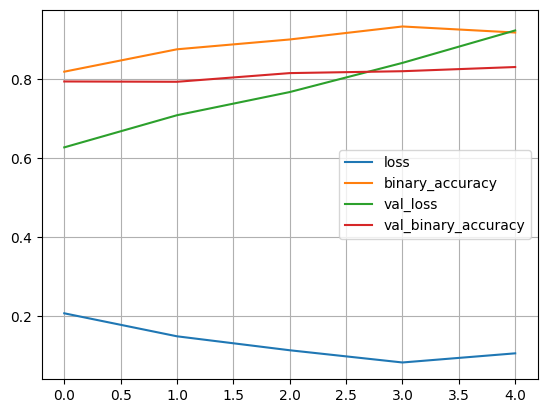

782/782 - 4s - loss: 1.0537 - binary_accuracy: 0.8280 - 4s/epoch - 6ms/step


[1.0537110567092896, 0.8279600143432617]

In [43]:
pd.DataFrame(history.history).plot() 
plt.grid(True)
plt.show()
model.evaluate(test_ds,verbose=2)

In [ ]:
#原有模型基础上，改造为能直接处理原始字符的模型
#将vectorize_layer加入原有模型的最上层

export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])


# bce 概率值值域范围 [0, 1]
#则应该设置为 from_logits=False，否则设置为True

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="nadam", metrics=['accuracy']
)

# 直接评估，无需拟合，使用raw数据集
export_model.evaluate(raw_test_ds)


examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

## RNN

In [49]:
rnn_model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim,mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64,activation="relu"),
    layers.Dense(1)
])
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640064    
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714433 (2.73 MB)
Trainable params: 714433 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
 
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

rnn_model.compile(loss=losses.BinaryCrossentropy(from_logits=True), #二元交叉熵
              optimizer=optimizer,
              metrics=['accuracy'])
    
history = rnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)  

Epoch 1/10
625/625 [==============================] - 60s 88ms/step - loss: 0.5852 - accuracy: 0.6247 - val_loss: 0.3895 - val_accuracy: 0.8164
Epoch 2/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3225 - accuracy: 0.8658 - val_loss: 0.3257 - val_accuracy: 0.8560
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.2374 - accuracy: 0.9100 - val_loss: 0.3470 - val_accuracy: 0.8642
Epoch 4/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1890 - accuracy: 0.9318 - val_loss: 0.3387 - val_accuracy: 0.8704
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1552 - accuracy: 0.9455 - val_loss: 0.3686 - val_accuracy: 0.8714
Epoch 6/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1359 - accuracy: 0.9536 - val_loss: 0.3683 - val_accuracy: 0.8734
Epoch 7/10
625/625 [==============================] - 32s 52ms/step - loss: 0.1248 - accuracy: 0.9581 - val_loss: 0.4016 - val_accuracy:

In [54]:
export_rnnmodel = tf.keras.Sequential([
    vectorize_layer,
    rnn_model,
    layers.Activation('sigmoid')
])


# bce 概率值值域范围 [0, 1]
#则应该设置为 from_logits=False，否则设置为True

export_rnnmodel.compile(
    loss=losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']
)

# 直接评估，无需拟合，使用raw数据集
export_model.evaluate(raw_test_ds)

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_rnnmodel.predict(examples)

1/1 [==============================] - 2s 2s/step


array([[0.70606035],
       [0.20145966],
       [0.1363936 ]], dtype=float32)

## TF HUB

In [1]:
#用TF_hub 处理embedding 

import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

2024-05-13 17:55:15.772923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:55:15.772973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:55:15.773734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 17:55:15.778130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:55:16.437200: W tensorflow/compiler/tf2

In [63]:
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [3]:
#使用标准数据集

train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

2024-05-13 17:55:25.377408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 17:55:25.396474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 17:55:25.397312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 17:55:25.399674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 17:55:25.400533: I external/local_xla/xla/stream_executor

In [4]:
batch_size=128
train_data=train_data.shuffle(10000).batch(batch_size)
validation_data=validation_data.shuffle(10000).batch(batch_size)
test_data=test_data.shuffle(10000).batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

google/nnlm-en-dim50/2 可将句子拆分为词例，嵌入每个词例，然后组合嵌入向量

google/nnlm-en-dim128/2 - 基于与 google/nnlm-en-dim50/2 相同的数据并使用相同的 NNLM 架构进行训练，但具有更大的嵌入向量维度。

google/nnlm-en-dim128-with-normalization/2 - 与 google/nnlm-en-dim128/2 相同，但具有额外的文本归一化，例如移除标点符号。如果文本包含附加字符或标点符号，这会有所帮助。

google/universal-sentence-encoder/4 - 一个可产生 512 维嵌入向量的大得多的模型，使用深度平均网络 (DAN) 编码器训练。

embeding更大维度的嵌入向量可以改进任务，但可能需要更长的时间来训练模型。

In [5]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124644769 (475.48 MB)
Trainable params: 124644769 (475.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model.compile(optimizer='nadam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

callbacks = [early_stopping_cb]

model.fit(train_data,epochs=20,validation_data=validation_data,callbacks=callbacks)


Epoch 1/20


2024-05-13 17:55:30.757832: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 17:55:33.511407: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f529f070690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 17:55:33.511443: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-13 17:55:33.522787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 17:55:33.901850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715594134.042079    8677 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    118/Unknown - 22s 142ms/step - loss: 0.4847 - accuracy: 0.7716

2024-05-13 17:55:51.161131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8655504592911414377
2024-05-13 17:55:51.161188: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13129616213231508747
2024-05-13 17:55:51.161197: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16606468093483628033
2024-05-13 17:55:51.161202: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13478886873540707594
2024-05-13 17:55:52.721306: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1509845957437982729
2024-05-13 17:55:52.721362: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18128827967002548081
2024-05-13 17:55:52.721380: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

118/118 [==============================] - 24s 160ms/step - loss: 0.4847 - accuracy: 0.7716 - val_loss: 0.3181 - val_accuracy: 0.8755
Epoch 2/20
118/118 [==============================] - 5s 45ms/step - loss: 0.2214 - accuracy: 0.9175 - val_loss: 0.2653 - val_accuracy: 0.8906
Epoch 3/20
118/118 [==============================] - 5s 40ms/step - loss: 0.1170 - accuracy: 0.9621 - val_loss: 0.2732 - val_accuracy: 0.8920
Epoch 4/20
118/118 [==============================] - 5s 41ms/step - loss: 0.0584 - accuracy: 0.9850 - val_loss: 0.2989 - val_accuracy: 0.8897
Epoch 5/20
118/118 [==============================] - 5s 41ms/step - loss: 0.0276 - accuracy: 0.9951 - val_loss: 0.3378 - val_accuracy: 0.8881
Epoch 6/20
118/118 [==============================] - 5s 41ms/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.4039 - val_accuracy: 0.8828
Epoch 7/20
118/118 [==============================] - 5s 41ms/step - loss: 0.0075 - accuracy: 0.9996 - val_loss: 0.4024 - val_accuracy: 0.8863
Epoch 8/

In [8]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model.predict(examples)

1/1 [==============================] - 0s 144ms/step


array([[0.91712916],
       [0.03847715],
       [0.02303125]], dtype=float32)

In [5]:
#使用谷歌最大的自然语言模型,模型过大训练太慢
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=False, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_data,epochs=10,validation_data=validation_data)

Epoch 1/10


2024-05-13 17:45:02.520464: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 17:45:06.719282: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f57d8820fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 17:45:06.719326: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-13 17:45:06.728605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 17:45:07.124385: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715593507.215452    5043 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     30/Unknown - 18s 368ms/step - loss: 0.6422 - accuracy: 0.7447

2024-05-13 17:45:18.186639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 557259374750571018
2024-05-13 17:45:18.186689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 216895997430162184
2024-05-13 17:45:18.186698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8705431586155211878
2024-05-13 17:45:18.186702: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4628808811377923572
2024-05-13 17:45:18.186707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9277601249586903393
2024-05-13 17:45:18.186711: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2171447169088281305
2024-05-13 17:45:18.186715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item 

30/30 [==============================] - 26s 658ms/step - loss: 0.6422 - accuracy: 0.7447 - val_loss: 0.5631 - val_accuracy: 0.8163
Epoch 2/10


2024-05-13 17:45:26.566990: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12119825626211117688
2024-05-13 17:45:26.567039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10659778076354316836
2024-05-13 17:45:26.567048: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16618862722038125782
2024-05-13 17:45:26.567052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14705137502618824216
2024-05-13 17:45:26.567056: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10310341642964228473
2024-05-13 17:45:26.567060: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15119955862671645257
2024-05-13 17:45:26.567063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous re

30/30 [==============================] - 19s 638ms/step - loss: 0.4995 - accuracy: 0.8241 - val_loss: 0.4424 - val_accuracy: 0.8306
Epoch 3/10
30/30 [==============================] - 19s 641ms/step - loss: 0.4073 - accuracy: 0.8401 - val_loss: 0.3841 - val_accuracy: 0.8433
Epoch 4/10
30/30 [==============================] - 19s 640ms/step - loss: 0.3646 - accuracy: 0.8511 - val_loss: 0.3587 - val_accuracy: 0.8485
Epoch 5/10
30/30 [==============================] - 19s 633ms/step - loss: 0.3444 - accuracy: 0.8569 - val_loss: 0.3463 - val_accuracy: 0.8512
Epoch 6/10
30/30 [==============================] - 19s 649ms/step - loss: 0.3336 - accuracy: 0.8595 - val_loss: 0.3395 - val_accuracy: 0.8521
Epoch 7/10
30/30 [==============================] - 19s 630ms/step - loss: 0.3270 - accuracy: 0.8607 - val_loss: 0.3356 - val_accuracy: 0.8536
Epoch 8/10
30/30 [==============================] - 18s 622ms/step - loss: 0.3227 - accuracy: 0.8623 - val_loss: 0.3333 - val_accuracy: 0.8541
Epoch 9/10

In [7]:
model.predict([
  "The movie was wonderfulllll !!!"
])

1/1 [==============================] - 0s 77ms/step


array([[0.29867086]], dtype=float32)

## BERT